In [16]:
import warnings

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor, early_stopping
from optuna import logging
from optuna.distributions import CategoricalDistribution as CatDist
from optuna.distributions import FloatDistribution as FloatDist
from optuna.distributions import IntDistribution as IntDist
from optuna.exceptions import ExperimentalWarning
from optuna.integration import OptunaSearchCV
from sklearn.compose import make_column_transformer
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, RepeatedKFold, cross_val_score
from sklearn.pipeline import FunctionTransformer, make_pipeline
from sklearn.preprocessing import StandardScaler

logging.set_verbosity(logging.WARNING)
warnings.filterwarnings("ignore", category=ExperimentalWarning)


In [259]:
numeric_cols = [
    "pressure [MPa]",
    "mass_flux [kg/m2-s]",
    "x_e_out [-]",
    "D_e [mm]",
    "D_h [mm]",
    "length [mm]",
    "chf_exp [MW/m2]",
    "id",
]

synthetic = pd.read_csv("data/data.csv", index_col="id", usecols=numeric_cols)
originals = pd.read_csv("data/original.csv", index_col="id", usecols=numeric_cols)

synthetic.columns = synthetic.columns.str.replace(r"\s?\[.*?\]", "", regex=True)
originals.columns = originals.columns.str.replace(r"\s?\[.*?\]", "", regex=True)

assert np.all(synthetic.columns == originals.columns)


In [260]:
def remove_duplicates(data):
    return data[~(data.duplicated() & data.x_e_out.notna())]


In [261]:
def remove_outliers(
    data,
    x_e_out_force_remove=False,
    force_remove_threshold=-0.6,
    contamination="auto",
    random_state=None,
    **kwargs
):
    if x_e_out_force_remove:
        data = data.drop(data[data.x_e_out < force_remove_threshold].index)

    isolation_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        **kwargs,
    )

    data_notna = data[~data.isna().any(axis=1)]
    forest_result = isolation_forest.fit_predict(data_notna.to_numpy())
    outlier_ids = pd.Series(forest_result == -1, index=data_notna.index)
    data_ids = pd.Series(np.zeros_like(data.index), index=data.index, dtype=bool)

    return data[~(outlier_ids | data_ids)]


In [262]:
def fillna_within_groupby(data, by, cols_to_fill, strategy="mean"):
    strategy_func = getattr(pd.Series, strategy)
    filled = data.groupby(by)[cols_to_fill].transform(
        lambda x: x.fillna(strategy_func(x))
    )
    cols_to_join = np.setdiff1d(data.columns.to_list(), cols_to_fill)
    return filled.join(data[cols_to_join])


In [263]:
final_preprocess = make_pipeline(
    make_column_transformer(
        (
            StandardScaler(),
            ["pressure", "mass_flux"],
        ),
        (
            make_pipeline(
                FunctionTransformer(  # Because of better fit to normal distribution.
                    func=np.log,
                    inverse_func=np.exp,
                    feature_names_out="one-to-one",
                ),
                StandardScaler(),
            ),
            ["D_e", "D_h", "chf_exp"],
        ),
        (
            make_pipeline(
                FunctionTransformer(  # Because of better fit to normal distribution.
                    func=np.log,
                    inverse_func=np.exp,
                    feature_names_out="one-to-one",
                ),
                StandardScaler(),
            ),
            ["length"],
        ),
        remainder="drop",
        verbose_feature_names_out=False,
    ),
    KNNImputer(n_neighbors=20, weights="distance"),
)


In [264]:
preliminary_processed_data = (
    synthetic.pipe(remove_duplicates)
    .pipe(
        remove_outliers,
        x_e_out_force_remove=True,
        random_state=42,
        bootstrap=True,
    )
    .pipe(
        fillna_within_groupby,
        by="chf_exp",  # Because of correlations.
        cols_to_fill=["pressure", "mass_flux", "length"],
        strategy="mean",
    )
    .pipe(
        fillna_within_groupby,
        by="pressure",  # Because of correlations.
        cols_to_fill=["D_e", "D_h"],
        strategy="mean",
    )
)

X = pd.DataFrame(
    final_preprocess.fit_transform(preliminary_processed_data),
    columns=final_preprocess.get_feature_names_out(),
    index=preliminary_processed_data.index,
)
y = preliminary_processed_data.x_e_out

X_train = X[y.notna()].to_numpy()
y_train = y[y.notna()].to_numpy()

X_valid = final_preprocess.transform(originals)
y_valid = originals.x_e_out.to_numpy()

X_test = X[y.isna()].to_numpy()
X_test_ids = X[y.isna()].index


In [256]:
X_train_orig = np.concatenate([X_train, X_valid])
y_train_orig = np.concatenate([y_train, y_valid])

In [265]:
PATIENCE = 20

lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}


lgbm = LGBMRegressor(**lgbm_kwargs).fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    callbacks=[
        early_stopping(stopping_rounds=PATIENCE, verbose=False),
    ],
)

catboost = CatBoostRegressor(**catboost_kwargs).fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=PATIENCE,
)

scores = -cross_val_score(
    LGBMRegressor(**lgbm_kwargs),
    X_train,
    y_train,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    error_score="raise",  # type: ignore
    # fit_params=dict(
    #     eval_set=(X_valid, y_valid),
    #     early_stopping_rounds=PATIENCE,
    # )
    fit_params=dict(
        eval_set=(X_valid, y_valid),
        callbacks=[early_stopping(stopping_rounds=PATIENCE, verbose=False)],
    ),
)
pd.Series(scores).describe()


count    5.000000
mean     0.069171
std      0.001157
min      0.068050
25%      0.068195
50%      0.069069
75%      0.069672
max      0.070869
dtype: float64

In [269]:
lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

lgbm = LGBMRegressor(**lgbm_kwargs)
lgbm_space = {
    "num_leaves": IntDist(16, 64),
    "max_depth": IntDist(2, 5),
    "learning_rate": FloatDist(1e-3, 5e-1, log=True),
    "n_estimators": IntDist(300, 3000, step=100),
    "min_split_gain": FloatDist(1e-3, 5e-1, log=True),
    "min_child_weight": FloatDist(1e-3, 5e-1, log=True),
    "min_child_samples": IntDist(32, 256, step=16),
    "subsample": FloatDist(0.2, 0.8),
    "colsample_bytree": FloatDist(0.2, 0.8),
    "importance_type": CatDist(["split", "gain"]),
    "reg_alpha": FloatDist(1e-2, 1e2, log=True),
    "reg_lambda": FloatDist(1e-2, 1e2, log=True),
}
lgbm_opt = OptunaSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_space,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_trials=300,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=42,
)
lgbm_opt.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    callbacks=[early_stopping(stopping_rounds=PATIENCE, verbose=False)],
)


OptunaSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
               error_score='raise', estimator=LGBMRegressor(random_state=42),
               n_jobs=-1, n_trials=300,
               param_distributions={'learning_rate': FloatDistribution(high=0.5, log=True, low=0.001, step=None),
                                    'max_depth': IntDistribution(high=5, log=False, low=2, step=1),
                                    'n_estimators': IntDistribution(high=3000, log=False, low=300, step=100),
                                    'num_leaves': IntDistribution(high=64, log=False, low=16, step=1)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [270]:
lgbm_opt.best_params_

{'num_leaves': 50,
 'max_depth': 5,
 'learning_rate': 0.18865523909799312,
 'n_estimators': 2500}

In [271]:
lgbm_opt.best_score_

-0.06947496650829436

In [79]:
catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}

catboost = CatBoostRegressor(**catboost_kwargs)
catboost_space = {
    "iterations": IntDist(300, 3000, step=200),
    "learning_rate": FloatDist(5e-4, 5e-1, log=True),
    "depth": IntDist(2, 10),
    "l2_leaf_reg": FloatDist(1e-2, 1e2, log=True),
    "colsample_bylevel": FloatDist(1e-2, 9e-1, log=True),
    "min_data_in_leaf": IntDist(32, 256, step=16),
    "random_strength": FloatDist(1e-2, 1e1, log=True),
    "bagging_temperature": FloatDist(1e-2, 1e2, log=True),
}
cat_boost_opt = OptunaSearchCV(
    estimator=catboost,
    param_distributions=catboost_space,
    cv=KFold(n_splits=3, shuffle=True, random_state=42),
    n_trials=300,
    n_jobs=-1,
    verbose=0,
    scoring="neg_root_mean_squared_error",
    error_score="raise",
    random_state=42,
)
cat_boost_opt.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=PATIENCE,
)


OptunaSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
               error_score='raise',
               estimator=<catboost.core.CatBoostRegressor object at 0x00000171EDCD5A50>,
               n_jobs=-1, n_trials=300,
               param_distributions={'bagging_temperature': FloatDistribution(high=100.0, log=True, low=0.01, step=None),
                                    'colsample_bylevel': FloatDistribution(high=0.9, log=True, low=0.01, step=None),
                                    'random_strength': FloatDistribution(high=10.0, log=True, low=0.01, step=None)},
               random_state=42, scoring='neg_root_mean_squared_error')

In [83]:
cat_boost_opt.best_params_

{'colsample_bylevel': 0.44513839103691155,
 'random_strength': 0.5326573155367901,
 'bagging_temperature': 0.2787304736712271}

In [84]:
cat_boost_opt.best_score_

-0.07022627484246735

In [279]:
lgbm_kwargs = {
    "random_state": 42,
    "num_leaves": 21,
    "max_depth": 5,
    "learning_rate": 0.12,
    "n_estimators": 1100,
    "min_split_gain": 1e-3,
    "min_child_weight": 1e-2,
    "min_child_samples": 32,
    "subsample": 0.2,
    "colsample_bytree": 0.6,
    "importance_type": "split",
    "reg_alpha": 0.1,
    "reg_lambda": 10.0,
}

catboost_kwargs = {
    "random_seed": 42,
    "silent": True,
    "allow_writing_files": False,
    "od_type": "Iter",
    "eval_metric": "RMSE",
    "bootstrap_type": "Bayesian",
    "grow_policy": "Lossguide",
    "iterations": 2300,
    "learning_rate": 0.05,
    "depth": 5,
    "l2_leaf_reg": 27.0,
    "min_data_in_leaf": 48,
    "colsample_bylevel": 0.5,
    "random_strength": 0.5,
    "bagging_temperature": 0.3,
}

PATIENCE = 20
SPLITS = 20

lgbm = LGBMRegressor(**lgbm_kwargs)
catboost = CatBoostRegressor(**catboost_kwargs)
kfold = KFold(n_splits=SPLITS, shuffle=True, random_state=42)
y_true, y_pred, rmses = [], [], []


for k, (train_ids, test_ids) in enumerate(kfold.split(X_train, y_train)):

    X_train_k, y_train_k = X_train[train_ids], y_train[train_ids]
    X_test_k, y_test_k = X_train[test_ids], y_train[test_ids]

    lgbm.fit(
        X_train_k,
        y_train_k,
        eval_set=(X_valid, y_valid),
        callbacks=[
            early_stopping(stopping_rounds=PATIENCE, verbose=False),
        ],
    )

    catboost.fit(
        X_train_k,
        y_train_k,
        eval_set=(X_valid, y_valid),
        early_stopping_rounds=PATIENCE,
    )

    predictions = (lgbm.predict(X_test_k) + catboost.predict(X_test_k)) * 0.5
    predictions = predictions.round(4)  # Post-processing trick.

    y_true.append(y_test_k)
    y_pred.append(predictions)
    rmses.append(mean_squared_error(y_test_k, predictions, squared=False))


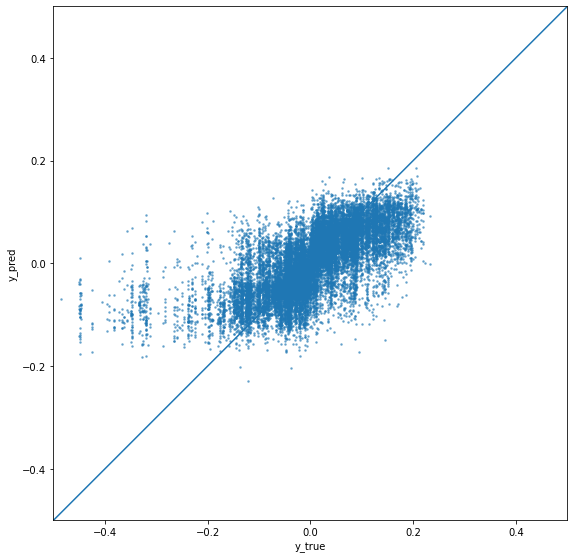

In [280]:
from matplotlib import pyplot as plt

Y_true = np.concatenate(y_true)
Y_pred = np.concatenate(y_pred)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), tight_layout=True)
ax.scatter(x=Y_true, y=Y_pred, alpha=0.5, marker=".", s=10)
ax.plot([-1, 1], [-1, 1])
ax.set_aspect(1.0)
ax.set_xlabel("y_true")
ax.set_ylabel("y_pred")
ax.axis([-0.5, 0.5, -0.5, 0.5])
plt.show()


In [281]:
pd.Series(rmses).describe()

count    20.000000
mean      0.068744
std       0.002661
min       0.063979
25%       0.066971
50%       0.068197
75%       0.070260
max       0.074496
dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x171fd139a20>,
 'caps': [<matplotlib.lines.Line2D at 0x171fd139fc0>,
 'boxes': [<matplotlib.lines.Line2D at 0x171fd139780>],
 'medians': [<matplotlib.lines.Line2D at 0x171fd13a560>],
 'fliers': [<matplotlib.lines.Line2D at 0x171fd13a830>],
 'means': []}

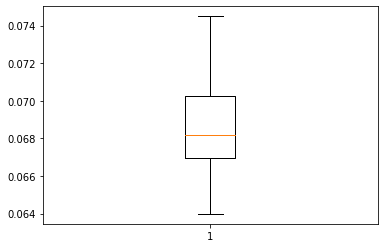

In [283]:
plt.boxplot(rmses)

In [240]:
lgbm.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    callbacks=[
        early_stopping(stopping_rounds=PATIENCE, verbose=False),
    ],
)

catboost.fit(
    X_train,
    y_train,
    eval_set=(X_valid, y_valid),
    early_stopping_rounds=PATIENCE,
)

predictions = ((lgbm.predict(X_test) + catboost.predict(X_test)) * 0.5).round(4)

submission = pd.DataFrame(
    {
        "id": X_test_ids,
        "x_e_out [-]": predictions,
    }
).set_index("id")

submission.to_csv("submission.csv")
submission.head()


,x_e_out [-]
id,
4,-0.0004
7,-0.0660
10,-0.0511
12,0.0004
23,0.0415


<AxesSubplot:ylabel='Frequency'>

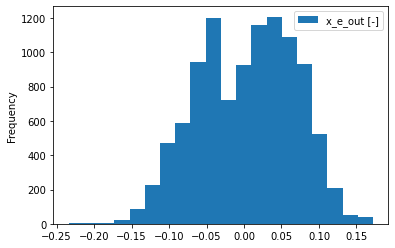

In [244]:
submission.plot(kind="hist", bins=20)